<a href="https://colab.research.google.com/github/NandavardhanRadhakrishnan/Class-incremental-learning/blob/main/NetworkOfModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


In [10]:
def create_mnist_data(num_classes, task_index, csv_file="mnist.csv", image_shape=(1, 28, 28)):
    mnist_file = open(csv_file)
    df = pd.read_csv(mnist_file)

    all_classes = sorted(df['label'].unique())
    start_class = task_index * num_classes
    end_class = start_class + num_classes
    valid_classes = all_classes[start_class:end_class]

    filtered_df = df[df['label'].isin(valid_classes)]

    X = filtered_df.drop(columns=['label']).values
    y = filtered_df['label'].values

    label_mapping = {cls: i for i, cls in enumerate(valid_classes)}
    y = np.array([label_mapping[label] for label in y])

    X = torch.tensor(X / 255.0, dtype=torch.float32)
    X = X.view(-1, *image_shape)
    y = torch.tensor(y, dtype=torch.long)

    return TensorDataset(X, y)


In [17]:
def inference_on_model(model, loader, num_classes, label_offset=0):
    all_preds = []
    all_labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)

            if len(images.shape) == 3:
                images = images.unsqueeze(1)

            logits = model(images)
            predictions = torch.argmax(logits, dim=1)

            # Apply label offset to predictions and labels
            all_preds.extend((predictions + label_offset).cpu().numpy())
            all_labels.extend((labels + label_offset).cpu().numpy())

            if batch_idx % 2000 == 0:
                print(f"Batch {batch_idx} Predictions:")
                print(f"Predicted: {(predictions + label_offset).cpu().numpy()}")
                print(f"True:      {(labels + label_offset).cpu().numpy()}")

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nAccuracy: {accuracy * 100:.2f}%")

    cm = confusion_matrix(all_labels, all_preds, labels=list(range(label_offset, label_offset + num_classes)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(range(label_offset, label_offset + num_classes)),
                yticklabels=list(range(label_offset, label_offset + num_classes)))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(cm)


In [12]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
def train_model(model, data_loader, criterion, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        with tqdm(total=len(data_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            for X_batch, y_batch in data_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                pbar.set_postfix(loss=total_loss / (pbar.n + 1))
                pbar.update(1)


In [14]:
def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total


In [15]:
num_classes_per_task = [5, 5]
image_shape = (1, 28, 28)

task1_data = create_mnist_data(num_classes_per_task[0], task_index=0, image_shape=image_shape)
task2_data = create_mnist_data(num_classes_per_task[1], task_index=1, image_shape=image_shape)
data = create_mnist_data(10, task_index=0, image_shape=image_shape)

task_data = [(task1_data, task1_data), (task2_data, task2_data)]

batch_size = 64
task1_loader = DataLoader(task1_data, batch_size=batch_size, shuffle=True)
task2_loader = DataLoader(task2_data, batch_size=batch_size, shuffle=True)
combined_data_loader = DataLoader(data, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Epoch 3/3: 100%|██████████| 322/322 [00:25<00:00, 12.87batch/s, loss=0.0301]



Evaluating Model 1 on Task 1:
Batch 0 Predictions:
Predicted: [4 3 4 3 3 2 1 2 4 1 4 4 2 3 4 2 3 0 0 1 4 3 2 2 4 0 1 2 0 3 4 1 4 3 2 0 1
 3 1 0 1 4 2 2 1 3 2 2 2 3 4 3 0 3 3 1 3 0 3 2 1 2 3 0]
True:      [4 3 4 3 3 2 1 2 4 1 4 4 2 3 4 2 3 0 0 1 4 3 2 2 4 0 1 2 0 3 4 1 4 3 2 0 1
 3 1 0 1 4 2 2 1 3 2 2 2 3 4 3 0 3 3 1 3 0 3 2 1 2 3 0]

Accuracy: 99.48%


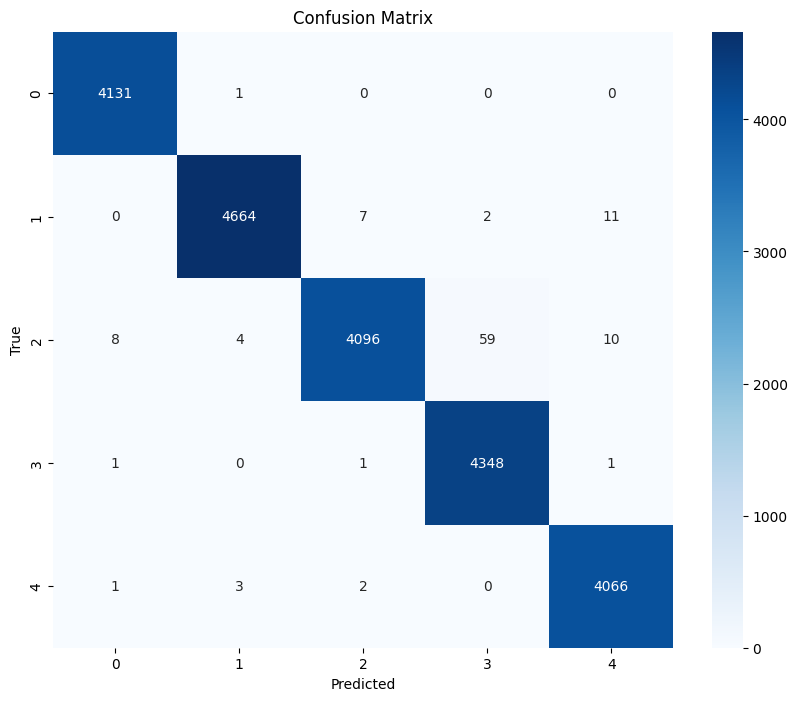

[[4131    1    0    0    0]
 [   0 4664    7    2   11]
 [   8    4 4096   59   10]
 [   1    0    1 4348    1]
 [   1    3    2    0 4066]]

Evaluating Model 2 on Task 2:
Batch 0 Predictions:
Predicted: [0 0 1 1 4 1 2 4 3 4 0 3 4 0 2 2 3 4 2 4 3 3 4 1 1 1 3 4 2 0 3 0 0 4 2 3 4
 0 3 0 4 2 3 1 4 3 3 3 0 0 3 0 0 1 4 1 0 2 1 2 0 3 2 2]
True:      [0 0 1 1 4 1 2 4 3 4 0 3 4 0 2 2 3 4 2 4 3 3 4 1 1 1 3 4 2 0 3 0 0 4 2 3 4
 0 3 0 4 2 3 1 4 3 3 3 0 0 3 0 0 1 4 1 0 2 1 2 0 3 2 2]

Accuracy: 99.27%


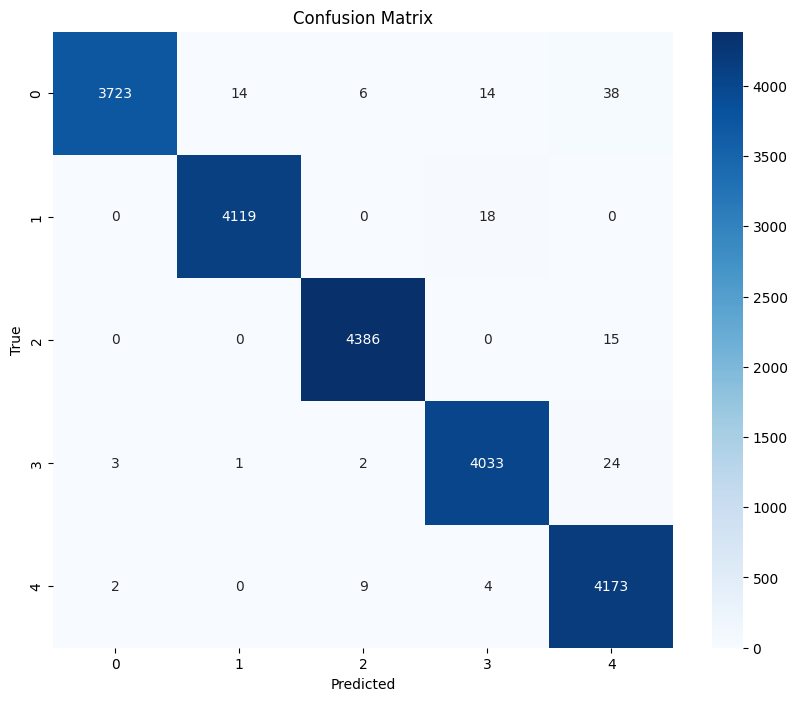

[[3723   14    6   14   38]
 [   0 4119    0   18    0]
 [   0    0 4386    0   15]
 [   3    1    2 4033   24]
 [   2    0    9    4 4173]]


In [16]:
model_1 = SimpleCNN(num_classes_per_task[0]).to(device)
criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001)
train_model(model_1, task1_loader, criterion_1, optimizer_1, epochs=3, device=device)

model_2 = SimpleCNN(num_classes_per_task[1]).to(device)
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)
train_model(model_2, task2_loader, criterion_2, optimizer_2, epochs=3, device=device)

Batch 0 Predictions:
Predicted: [0 0 1 2 1 4 3 4 2 2 1 0 0 1 0 4 2 0 4 2 2 0 0 3 0 3 3 2 2 2 3 2 3 3 4 4 2
 3 2 4 1 1 0 0 4 4 3 3 4 0 2 4 1 3 0 4 2 1 4 0 2 2 2 3]
True:      [0 0 1 2 1 4 3 4 2 2 1 0 0 1 0 4 2 0 4 2 2 0 0 3 0 3 3 2 2 2 3 2 3 3 4 4 2
 3 2 4 1 1 0 0 4 4 3 3 4 0 2 4 1 3 0 4 2 1 4 0 2 2 2 3]

Accuracy: 99.48%


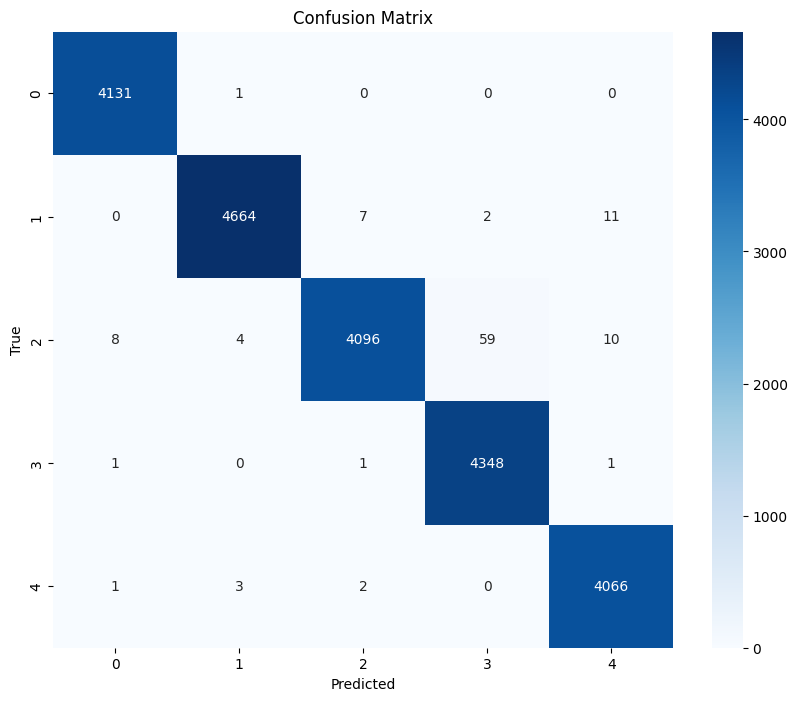

[[4131    1    0    0    0]
 [   0 4664    7    2   11]
 [   8    4 4096   59   10]
 [   1    0    1 4348    1]
 [   1    3    2    0 4066]]
Batch 0 Predictions:
Predicted: [7 7 6 9 8 6 7 5 9 9 5 9 5 5 5 7 8 9 9 7 6 6 8 9 7 6 8 8 9 7 9 8 8 7 6 8 8
 7 8 7 9 6 5 5 8 9 7 8 5 8 9 8 8 9 5 5 7 9 5 6 7 8 6 6]
True:      [7 7 6 9 8 6 7 5 9 9 5 9 5 5 5 7 8 9 9 7 6 6 8 9 7 6 8 8 9 7 9 8 8 7 6 8 5
 7 8 7 9 6 5 5 8 9 7 8 5 8 9 8 8 9 5 5 7 9 5 6 7 8 6 6]

Accuracy: 99.27%


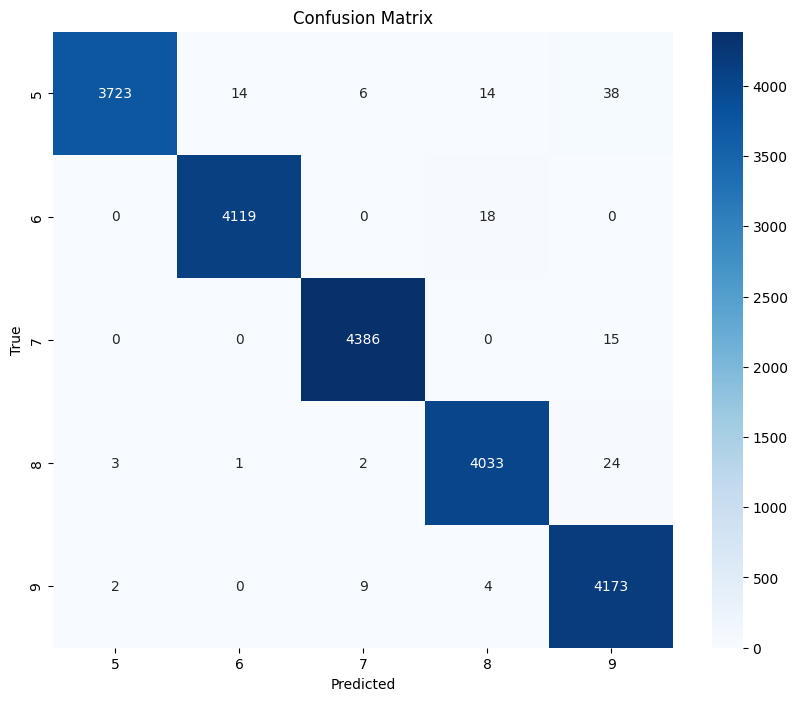

[[3723   14    6   14   38]
 [   0 4119    0   18    0]
 [   0    0 4386    0   15]
 [   3    1    2 4033   24]
 [   2    0    9    4 4173]]


In [18]:
inference_on_model(model_1, task1_loader, num_classes_per_task[0], label_offset=0)
inference_on_model(model_2, task2_loader, num_classes_per_task[1], label_offset=5)


In [19]:
def mnist_class(csv_file="mnist.csv", image_shape=(1, 28, 28)):
    mnist_file = open(csv_file)
    df = pd.read_csv(mnist_file)

    def relabel_digit(digit):
        return 0 if digit < 5 else 1  # 0-4 → Class 0, 5-9 → Class 1

    df['label'] = df['label'].apply(relabel_digit)

    X = df.drop(columns=['label']).values
    y = df['label'].values

    X = torch.tensor(X / 255.0, dtype=torch.float32)
    X = X.view(-1, *image_shape)
    y = torch.tensor(y, dtype=torch.long)

    return TensorDataset(X, y)


In [20]:
group_data = mnist_class()
batch_size = 64
group_loader = DataLoader(group_data, batch_size=batch_size, shuffle=True)

In [21]:
model_group = SimpleCNN(2).to(device)
criterion_group = nn.CrossEntropyLoss()
optimizer_group = optim.Adam(model_group.parameters(), lr=0.001)
train_model(model_group, group_loader, criterion_group, optimizer_group, epochs=3, device=device)

Epoch 3/3: 100%|██████████| 657/657 [00:51<00:00, 12.74batch/s, loss=0.0291]


Batch 0 Predictions:
Predicted: [0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0
 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
True:      [0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0
 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0]

Accuracy: 99.24%


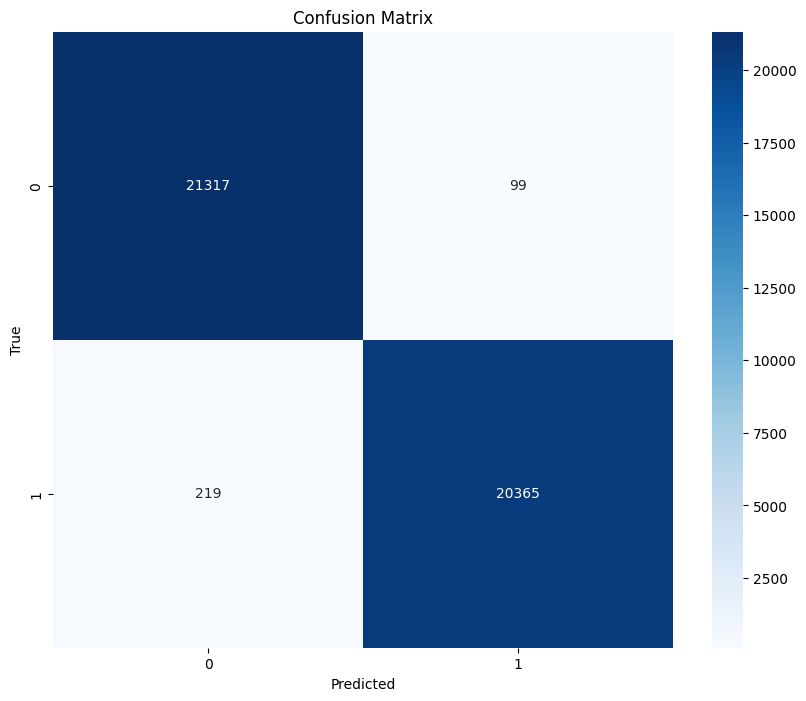

[[21317    99]
 [  219 20365]]


In [22]:
inference_on_model(model_group, group_loader, 2, label_offset=0)

In [23]:
def inference_with_grouping(model_1, model_2, model_group, combined_loader, num_classes_1=5, num_classes_2=5, index=None):
    all_preds = []
    all_labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_1.eval()
    model_2.eval()
    model_group.eval()

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(combined_loader):
            images, labels = images.to(device), labels.to(device)

            if len(images.shape) == 3:
                images = images.unsqueeze(1)

            # If index is provided, infer only that index
            if index is not None:
                images = images[index].unsqueeze(0)
                labels = labels[index].unsqueeze(0)

            # First, use model_group to classify into 0-4 or 5-9
            group_logits = model_group(images)
            group_pred = torch.argmax(group_logits, dim=1)  # 0 -> model_1 (0-4), 1 -> model_2 (5-9)

            # Predict with the appropriate model
            final_preds = []
            for i in range(images.shape[0]):
                if group_pred[i].item() == 0:
                    logits = model_1(images[i].unsqueeze(0))
                    pred = torch.argmax(logits, dim=1).item()  # No offset needed
                else:
                    logits = model_2(images[i].unsqueeze(0))
                    pred = torch.argmax(logits, dim=1).item() + num_classes_1  # Offset by 5

                final_preds.append(pred)

            all_preds.extend(final_preds)
            all_labels.extend(labels.cpu().numpy())

            if batch_idx % 2000 == 0 or index is not None:
                print(f"Batch {batch_idx} Predictions:")
                print(f"Predicted: {final_preds}")
                print(f"True:      {labels.cpu().numpy()}")

            if index is not None:  # If only one sample is requested, stop after processing it
                break

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes_1 + num_classes_2)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(range(num_classes_1 + num_classes_2)),
                yticklabels=list(range(num_classes_1 + num_classes_2)))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(cm)


Batch 0 Predictions:
Predicted: [1, 0, 1, 4, 0, 0, 7, 3, 5, 3, 8, 9, 1, 3, 3, 1, 2, 0, 7, 5, 8, 6, 2, 0, 2, 3, 6, 9, 9, 7, 8, 9, 4, 9, 2, 1, 3, 1, 1, 4, 9, 1, 4, 9, 2, 6, 3, 7, 7, 4, 7, 5, 1, 9, 0, 2, 2, 3, 9, 1, 1, 1, 5, 0]
True:      [1 0 1 4 0 0 7 3 5 3 8 9 1 3 3 1 2 0 7 5 8 6 2 0 2 3 6 9 9 7 8 9 4 9 2 1 3
 1 1 4 9 1 4 4 2 6 3 7 7 4 7 5 1 9 0 2 2 3 9 1 1 1 5 0]

Overall Accuracy: 98.64%


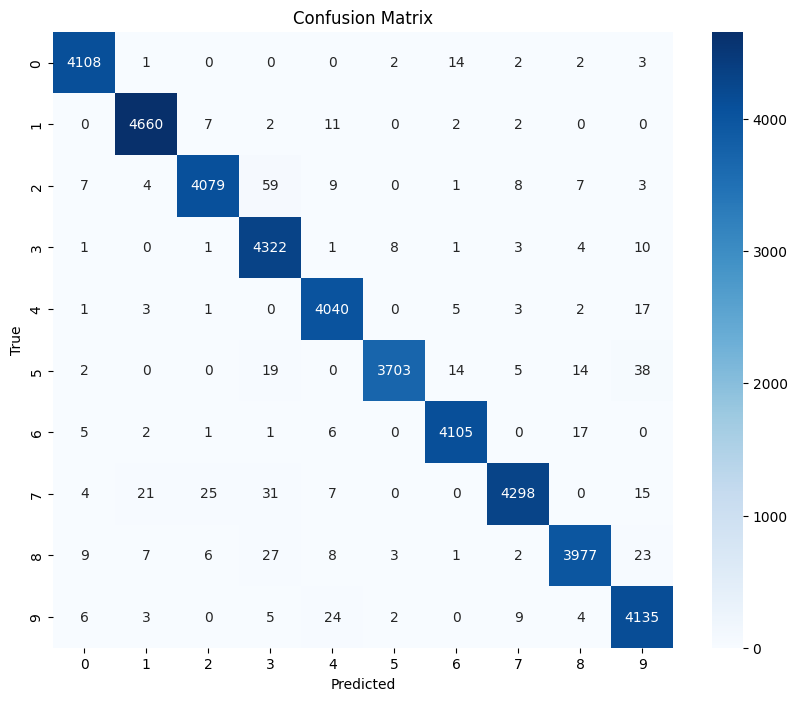

[[4108    1    0    0    0    2   14    2    2    3]
 [   0 4660    7    2   11    0    2    2    0    0]
 [   7    4 4079   59    9    0    1    8    7    3]
 [   1    0    1 4322    1    8    1    3    4   10]
 [   1    3    1    0 4040    0    5    3    2   17]
 [   2    0    0   19    0 3703   14    5   14   38]
 [   5    2    1    1    6    0 4105    0   17    0]
 [   4   21   25   31    7    0    0 4298    0   15]
 [   9    7    6   27    8    3    1    2 3977   23]
 [   6    3    0    5   24    2    0    9    4 4135]]


In [26]:
inference_with_grouping(model_1, model_2, model_group, combined_data_loader)
